In [1]:
import os
#os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from pennylane import AngleEmbedding, StronglyEntanglingLayers, RandomLayers
import pennylane as qml
import os
import jax
from jax import numpy as jnp
import equinox as eqx
import time
from tqdm import tqdm
import optax
import tensorflow as tf
from jaxtyping import Array, Float, PyTree
from collections import deque

In [2]:
print(jax.devices())

[cuda(id=0)]


In [3]:
key = jax.random.PRNGKey(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train = x_train[:100_000]
y_train = y_train[:100_000]

x_test = x_test[:40_000]
y_test = y_test[:40_000]

In [6]:
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [7]:
x_train = jnp.expand_dims(x_train, axis=-1)
x_test = jnp.expand_dims(x_test, axis=-1)

In [8]:
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

In [9]:
y_train = jax.nn.one_hot(y_train, 10)
y_test = jax.nn.one_hot(y_test, 10)

In [10]:
num_qubits = 8
in_channel = 2
kernel_size = [2, 2]

In [11]:
device = qml.device("default.qubit.jax", wires=num_qubits)

@jax.jit
@qml.qnode(device, interface="jax")
def quantum_conv_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(num_qubits))
    
    for weight_set, cell_qubit in enumerate(range(0, num_qubits, in_channel)):
        
        for channel_qubit in range(0, in_channel):
            if cell_qubit + channel_qubit != cell_qubit:
                qml.CNOT(wires=[cell_qubit + channel_qubit, cell_qubit])
        qml.Rot(weights[weight_set, 0], weights[weight_set, 1], weights[weight_set, 2], wires=cell_qubit)
        
        if cell_qubit > 0:
            qml.CNOT(wires=[cell_qubit, 0])
    
    qml.Rot(weights[-1, 0], weights[-1, 1], weights[-1, 2], wires=0)
    #RandomLayers(weights, wires=range(self.num_qubits))
    return qml.expval(qml.PauliZ(wires=0))

In [12]:
weights = jax.random.normal(jax.random.PRNGKey(0), (sum(kernel_size) + 1, 3))

In [13]:
quantum_conv_circuit(jnp.array([2, 2, 3, 2, 5, 6, 7, 8]), weights)

Array(0.05004174, dtype=float32)

/tmp/ipykernel_1758/2255298493.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


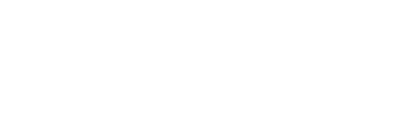

In [14]:
fig, ax = qml.draw_mpl(quantum_conv_circuit)(jnp.array([2, 2, 3, 2, 5, 6, 7, 8]), weights)
fig.show()

In [15]:
class QuantumConv2dLayer(eqx.Module):
    filter_size: int
    circuit_length: int
    padding_mode: str
    weight: jax.Array
    num_qubits: int
    quantum_conv_circuit: list
    kernel_size: tuple[int, int]
    stride: tuple[int, int]
    
    def __init__(self, filter_size, circuit_length, kernel_size, stride, padding_mode, in_channel):
        super().__init__()
        self.filter_size = filter_size
        self.circuit_length = circuit_length
        self.padding_mode = padding_mode
        
        self.num_qubits = in_channel * kernel_size[0] * kernel_size[1]
        self.weight = jax.random.normal(jax.random.PRNGKey(0), (filter_size, kernel_size[0] + kernel_size[1] + 1, 3))
        
        self.kernel_size = kernel_size
        self.stride = stride

        device = qml.device("default.qubit.jax", wires=self.num_qubits)
        @jax.jit
        @qml.qnode(device, interface="jax")
        def quantum_conv_circuit(inputs, weights):
            AngleEmbedding(inputs, wires=range(self.num_qubits))
            for weight_set, cell_qubit in enumerate(range(0, self.num_qubits, in_channel)):

                for channel_qubit in range(0, in_channel):
                    if cell_qubit + channel_qubit != cell_qubit:
                        qml.CNOT(wires=[cell_qubit + channel_qubit, cell_qubit])
                qml.Rot(weights[weight_set, 0], weights[weight_set, 1], weights[weight_set, 2], wires=cell_qubit)

                if cell_qubit > 0:
                    qml.CNOT(wires=[cell_qubit, 0])

                qml.Rot(weights[-1, 0], weights[-1, 1], weights[-1, 2], wires=0)
            return qml.expval(qml.PauliZ(wires=0))

        self.quantum_conv_circuit = [quantum_conv_circuit]
        
    @eqx.filter_jit
    def apply_on_batch(self, inputs):
        # Apply the quantum circuit to each patch
        inputs = jnp.transpose(inputs)
        outputs = []
                
        for i in range(self.filter_size):
            
            outputs.append(
                jnp.expand_dims(
                    jax.vmap(
                        self.quantum_conv_circuit[0], in_axes=(0, None)
                    )(inputs, self.weight[i]),
                    axis=0
                )
            )
        return jnp.concatenate(outputs, axis=0)
    
    @eqx.filter_jit
    def __call__(self, inputs):
        # Extract patches
        inputs = jnp.expand_dims(inputs, axis=0)
        patches = jax.lax.conv_general_dilated_patches(inputs, self.kernel_size, self.stride, self.padding_mode)
        patches_shape = patches.shape
        patches_flat = patches.reshape(patches_shape[0], patches_shape[1], patches_shape[2] * patches_shape[3])

        # Apply the quantum circuit on each patch
        output = jax.vmap(self.apply_on_batch)(patches_flat)
        output_shape = patches_shape
        
        output_shape = (self.filter_size, output_shape[2], output_shape[3])        
        # Reshape the output
        return output.reshape(output_shape)


In [16]:
class HybrideModel(eqx.Module):
    layers: list
    
    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.layers = [
            eqx.nn.Conv2d(1, 1, kernel_size=4, key=key1, stride=3),
            jax.nn.sigmoid,
            QuantumConv2dLayer(filter_size=8, circuit_length=1, kernel_size=(3, 3), stride=(2, 2), padding_mode='VALID', in_channel=1),
            eqx.nn.Conv2d(8, 12, kernel_size=2, key=key3, stride=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(48, 10, key=key3),
            jax.nn.softmax
        ]
        
    @eqx.filter_jit
    def __call__(self, x):
        
        for layer in self.layers:
            x = layer(x)
        return x
    
key, subkey = jax.random.split(key, 2)
model = HybrideModel(subkey)

In [17]:
@eqx.filter_jit
def categorical_crossentropy(model, inputs, targets):
    
    y_pred = jax.vmap(model)(inputs)
    
    y_pred = jnp.clip(y_pred, 1e-7, 1 - 1e-7)
    
    loss = -jnp.sum(targets * jnp.log(y_pred), axis=-1)
    
    return jnp.mean(loss), y_pred

@eqx.filter_jit
def categorical_accuracy(y_true, y_pred):
    true_labels = jnp.argmax(y_true, axis=-1)
    predicted_labels = jnp.argmax(y_pred, axis=-1)

    # Comparer les indices pour calculer la précision
    return jnp.mean(true_labels == predicted_labels)
    

@eqx.filter_jit
def train_step(model, opt_state, inputs, target):
    
    (loss_value, y_pred), grads = eqx.filter_value_and_grad(categorical_crossentropy, has_aux=True)(model, inputs, target)
    
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    
    accuracy = categorical_accuracy(target, y_pred)
    
    
    return model, opt_state, loss_value, accuracy

@eqx.filter_jit
def test_step(model, inputs, target):
    loss_value, y_pred = categorical_crossentropy(model, inputs, target)
    
    accuracy = categorical_accuracy(target, y_pred)
    
    return loss_value, accuracy
    

In [18]:
def batch(array, batch_size):
    return np.array_split(array, np.ceil(len(array) / batch_size))

In [19]:
optim = optax.adamax(0.002)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
epochs = 20
batch_size = 8

In [20]:
x_train_batch = batch(x_train, batch_size=batch_size)
y_train_batch = batch(y_train, batch_size=batch_size)

x_test_batch = batch(x_test, batch_size=batch_size)
y_test_batch = batch(y_test, batch_size=batch_size)

In [21]:
for step in range(epochs):
    accuracys = deque()
    losss = deque()
    print(f"Starting epoch: {step + 1}")
    
    for (x_batch, y_batch) in tqdm(zip(x_train_batch, y_train_batch), total=len(x_train_batch)):
        model, opt_state, loss_val, accuracy = train_step(model, opt_state, x_batch, y_batch)
        accuracys.append(accuracy)
        losss.append(loss_val)
    print(f"Train Loss: {np.mean(losss)}")
    print(f"Train Accuracy: {np.mean(accuracys)}")
    
    test_accuracys = deque()
    test_losss = deque()
    for (x_batch, y_batch) in tqdm(zip(x_test_batch, y_test_batch), total=len(x_test_batch)):
        loss_val, accuracy = test_step(model, x_batch, y_batch)
        
        test_accuracys.append(accuracy)
        test_losss.append(loss_val)
    print(f"Test Loss: {np.mean(test_losss)}")
    print(f"Test Accuracy: {np.mean(test_accuracys)}")
        

Starting epoch: 1


100%|██████████| 7500/7500 [01:11<00:00, 104.67it/s]


Train Loss: 1.090925693511963
Train Accuracy: 0.6467999815940857


100%|██████████| 1250/1250 [00:12<00:00, 99.93it/s] 


Test Loss: 0.7057780027389526
Test Accuracy: 0.7698000073432922
Starting epoch: 2


100%|██████████| 7500/7500 [00:54<00:00, 136.49it/s]


Train Loss: 0.633529543876648
Train Accuracy: 0.7980499863624573


100%|██████████| 1250/1250 [00:02<00:00, 419.63it/s]


Test Loss: 0.5502058863639832
Test Accuracy: 0.8264999985694885
Starting epoch: 3


100%|██████████| 7500/7500 [00:56<00:00, 133.86it/s]


Train Loss: 0.5266749262809753
Train Accuracy: 0.8317000269889832


100%|██████████| 1250/1250 [00:02<00:00, 423.78it/s]


Test Loss: 0.4722748100757599
Test Accuracy: 0.8495000004768372
Starting epoch: 4


100%|██████████| 7500/7500 [00:55<00:00, 133.95it/s]


Train Loss: 0.46068844199180603
Train Accuracy: 0.853683352470398


100%|██████████| 1250/1250 [00:02<00:00, 424.41it/s]


Test Loss: 0.4342370629310608
Test Accuracy: 0.8600999712944031
Starting epoch: 5


100%|██████████| 7500/7500 [00:55<00:00, 134.03it/s]


Train Loss: 0.42047199606895447
Train Accuracy: 0.8673166632652283


100%|██████████| 1250/1250 [00:02<00:00, 429.56it/s]


Test Loss: 0.3891635239124298
Test Accuracy: 0.8762999773025513
Starting epoch: 6


100%|██████████| 7500/7500 [00:56<00:00, 133.56it/s]


Train Loss: 0.38530024886131287
Train Accuracy: 0.8808500170707703


100%|██████████| 1250/1250 [00:02<00:00, 422.07it/s]


Test Loss: 0.35463693737983704
Test Accuracy: 0.8877999782562256
Starting epoch: 7


100%|██████████| 7500/7500 [00:55<00:00, 133.97it/s]


Train Loss: 0.35309159755706787
Train Accuracy: 0.8914166688919067


100%|██████████| 1250/1250 [00:02<00:00, 423.89it/s]


Test Loss: 0.3250654637813568
Test Accuracy: 0.8985999822616577
Starting epoch: 8


100%|██████████| 7500/7500 [00:55<00:00, 133.95it/s]


Train Loss: 0.33014342188835144
Train Accuracy: 0.8991333246231079


100%|██████████| 1250/1250 [00:02<00:00, 428.50it/s]


Test Loss: 0.3050464987754822
Test Accuracy: 0.9052000045776367
Starting epoch: 9


100%|██████████| 7500/7500 [00:55<00:00, 134.02it/s]


Train Loss: 0.3123653829097748
Train Accuracy: 0.904783308506012


100%|██████████| 1250/1250 [00:02<00:00, 422.48it/s]


Test Loss: 0.29002007842063904
Test Accuracy: 0.9104999899864197
Starting epoch: 10


100%|██████████| 7500/7500 [00:55<00:00, 133.94it/s]


Train Loss: 0.29819780588150024
Train Accuracy: 0.9087166786193848


100%|██████████| 1250/1250 [00:02<00:00, 424.49it/s]


Test Loss: 0.2739640176296234
Test Accuracy: 0.9157999753952026
Starting epoch: 11


100%|██████████| 7500/7500 [00:55<00:00, 133.99it/s]


Train Loss: 0.2858319878578186
Train Accuracy: 0.9123499989509583


100%|██████████| 1250/1250 [00:02<00:00, 423.70it/s]


Test Loss: 0.26580914855003357
Test Accuracy: 0.9186999797821045
Starting epoch: 12


100%|██████████| 7500/7500 [00:56<00:00, 133.87it/s]


Train Loss: 0.27565911412239075
Train Accuracy: 0.9150000214576721


100%|██████████| 1250/1250 [00:02<00:00, 423.15it/s]


Test Loss: 0.2566033601760864
Test Accuracy: 0.9215999841690063
Starting epoch: 13


100%|██████████| 7500/7500 [00:56<00:00, 133.66it/s]


Train Loss: 0.26611363887786865
Train Accuracy: 0.9178833365440369


100%|██████████| 1250/1250 [00:02<00:00, 425.44it/s]


Test Loss: 0.2516675889492035
Test Accuracy: 0.9222999811172485
Starting epoch: 14


100%|██████████| 7500/7500 [00:56<00:00, 133.44it/s]


Train Loss: 0.25807511806488037
Train Accuracy: 0.9203166961669922


100%|██████████| 1250/1250 [00:02<00:00, 419.66it/s]


Test Loss: 0.24716763198375702
Test Accuracy: 0.9247999787330627
Starting epoch: 15


100%|██████████| 7500/7500 [00:56<00:00, 133.40it/s]


Train Loss: 0.2501511573791504
Train Accuracy: 0.9231333136558533


100%|██████████| 1250/1250 [00:02<00:00, 421.71it/s]


Test Loss: 0.24116870760917664
Test Accuracy: 0.925599992275238
Starting epoch: 16


100%|██████████| 7500/7500 [00:56<00:00, 133.48it/s]


Train Loss: 0.24290670454502106
Train Accuracy: 0.9254999756813049


100%|██████████| 1250/1250 [00:02<00:00, 420.68it/s]


Test Loss: 0.23716093599796295
Test Accuracy: 0.9283000230789185
Starting epoch: 17


100%|██████████| 7500/7500 [00:56<00:00, 133.46it/s]


Train Loss: 0.236563041806221
Train Accuracy: 0.9278666377067566


100%|██████████| 1250/1250 [00:02<00:00, 424.30it/s]


Test Loss: 0.22801223397254944
Test Accuracy: 0.9304999709129333
Starting epoch: 18


100%|██████████| 7500/7500 [00:56<00:00, 132.74it/s]


Train Loss: 0.23014244437217712
Train Accuracy: 0.9296000003814697


100%|██████████| 1250/1250 [00:02<00:00, 426.45it/s]


Test Loss: 0.21773554384708405
Test Accuracy: 0.9320999979972839
Starting epoch: 19


100%|██████████| 7500/7500 [00:56<00:00, 133.62it/s]


Train Loss: 0.22511595487594604
Train Accuracy: 0.9315000176429749


100%|██████████| 1250/1250 [00:02<00:00, 424.59it/s]


Test Loss: 0.21281252801418304
Test Accuracy: 0.9329000115394592
Starting epoch: 20


100%|██████████| 7500/7500 [00:55<00:00, 135.27it/s]


Train Loss: 0.22052864730358124
Train Accuracy: 0.9328833222389221


100%|██████████| 1250/1250 [00:02<00:00, 422.08it/s]


Test Loss: 0.21010683476924896
Test Accuracy: 0.9343000054359436
